# Neural Networks with TensorBoard Visualization & Bayesian Optimization
## Iris Flower Dataset Classification Project

This notebook implements a neural network classification project using the Iris Flower Dataset, featuring:
- Data preprocessing and exploration
- Neural network implementation with TensorFlow/Keras
- TensorBoard visualization
- Bayesian hyperparameter optimization using Optuna
- Model evaluation and comparison
- Streamlit deployment preparation

In [5]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Deep learning imports
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Bayesian optimization
import optuna

# Visualization
import plotly.express as px
import plotly.graph_objects as go

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Part 1: Data Understanding and Preprocessing

In this section, we will:
1. Load the Iris dataset
2. Explore its structure and characteristics
3. Handle any missing values or outliers
4. Perform feature scaling
5. Split the data into training, validation, and test sets

In [6]:
# Load the Iris dataset
from sklearn.datasets import load_iris

# Load data
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name='species')

# Display basic information about the dataset
print("Dataset Shape:", X.shape)
print("\nFeature Names:", iris.feature_names)
print("\nTarget Names:", iris.target_names)
print("\nFirst few rows of the dataset:")
print(X.head())
print("\nBasic statistics of features:")
print(X.describe())

Dataset Shape: (150, 4)

Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Target Names: ['setosa' 'versicolor' 'virginica']

First few rows of the dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

Basic statistics of features:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000     

<Figure size 1200x800 with 0 Axes>

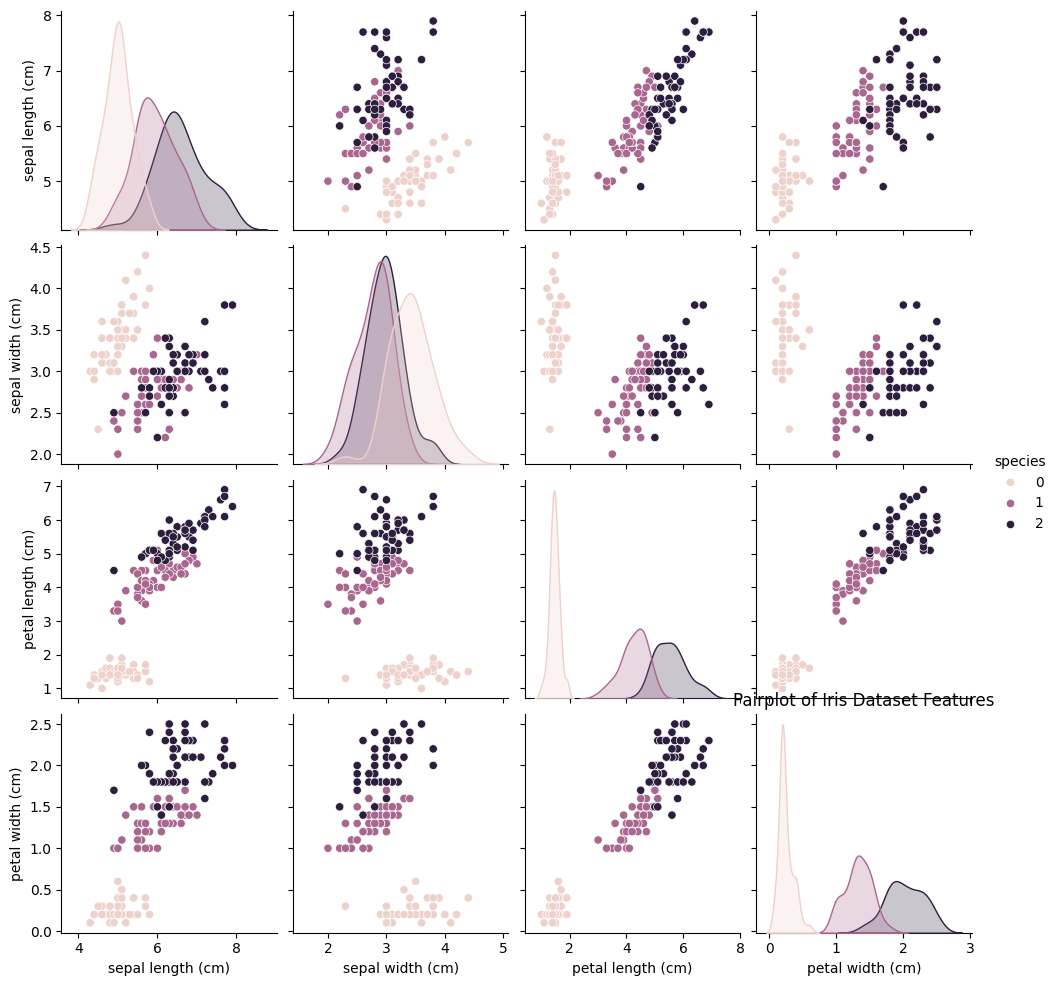


Missing values in the dataset:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64


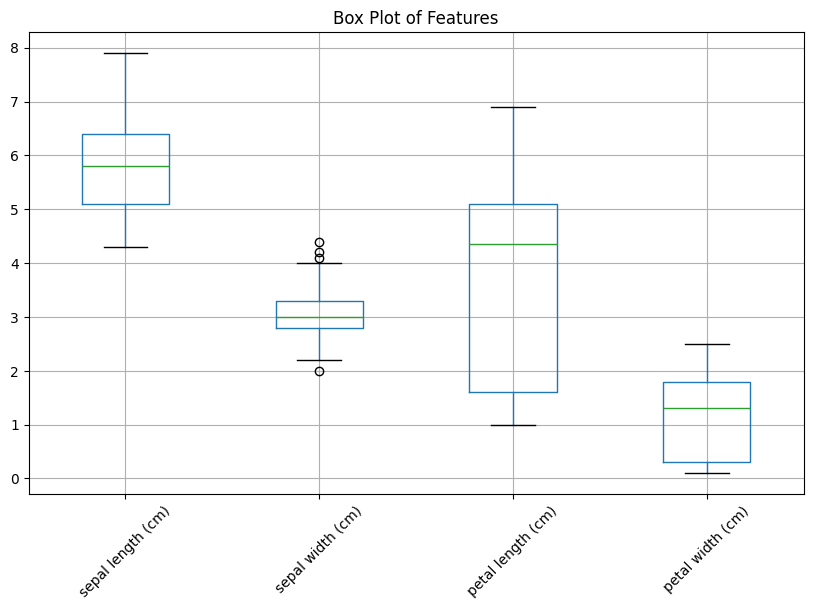


Data split shapes:
Training set: (96, 4)
Validation set: (24, 4)
Test set: (30, 4)


In [7]:
# Data Visualization
plt.figure(figsize=(12, 8))
sns.pairplot(data=pd.concat([X, y], axis=1), hue='species')
plt.title("Pairplot of Iris Dataset Features")
plt.show()

# Check for missing values
print("\nMissing values in the dataset:")
print(X.isnull().sum())

# Box plot to identify outliers
plt.figure(figsize=(10, 6))
X.boxplot()
plt.title("Box Plot of Features")
plt.xticks(range(1, len(iris.feature_names) + 1), iris.feature_names, rotation=45)
plt.show()

# Data Preprocessing
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print("\nData split shapes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

## Part 2: Building the Baseline Neural Network

In this section, we will:
1. Design a simple feedforward neural network
2. Set up TensorBoard logging
3. Train the baseline model
4. Evaluate initial performance

In [8]:
# Set up TensorBoard logging directory
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch'
)

# Define the baseline model
def create_baseline_model(input_shape, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and train the baseline model
input_shape = (X_train.shape[1],)
num_classes = len(np.unique(y_train))
baseline_model = create_baseline_model(input_shape, num_classes)

# Print model summary
baseline_model.summary()

c:\Users\M\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,499 (9.76 KB)

 Trainable params: 2,499 (9.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.5365 - loss: 1.0337 - val_accuracy: 0.5417 - val_loss: 1.0529
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6159 - loss: 0.9988 - val_accuracy: 0.5417 - val_loss: 1.0030
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6211 - loss: 0.9517 - val_accuracy: 0.5417 - val_loss: 0.9570
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6198 - loss: 0.9298 - val_accuracy: 0.5417 - val_loss: 0.9139
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6654 - loss: 0.8606 - val_accuracy: 0.5417 - val_loss: 0.8741
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6471 - loss: 0.8050 - val_accuracy: 0.5417 - val_loss: 0.8373
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6875 - loss: 0.7694 - val_accuracy: 0.5417 - val_loss: 0.8029
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6732 - loss: 0.7484 - val_accuracy: 0.5417 - val_loss: 0.7703

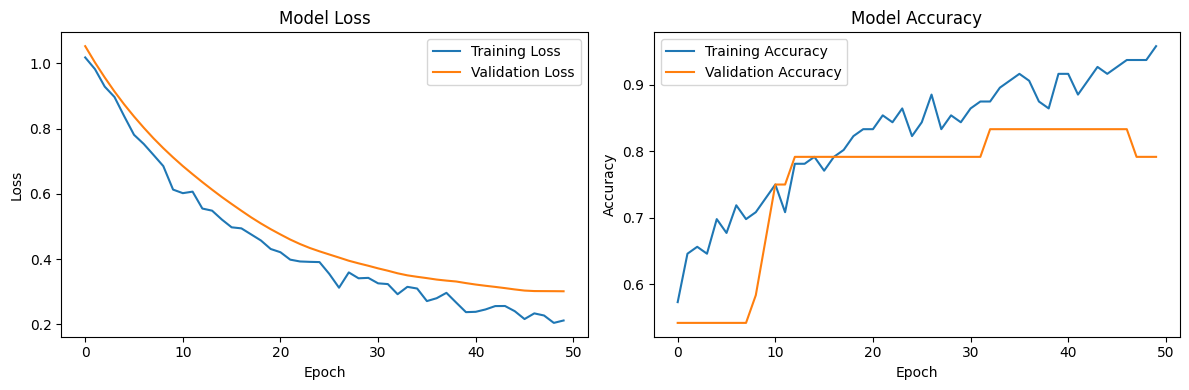

In [9]:
# Train the baseline model with TensorBoard logging
history = baseline_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard_callback]
)

# Evaluate baseline model
train_loss, train_accuracy = baseline_model.evaluate(X_train, y_train)
val_loss, val_accuracy = baseline_model.evaluate(X_val, y_val)
test_loss, test_accuracy = baseline_model.evaluate(X_test, y_test)

print("\nBaseline Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualize training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Part 3: TensorBoard Visualization and Analysis

In this section, we will:
1. Create additional model variants for comparison
2. Train models with different hyperparameters
3. Analyze training behavior through TensorBoard
4. Compare model performances

In [10]:
# Create model variants for comparison
def create_model_variant(input_shape, num_classes, variant_name):
    if variant_name == "deeper":
        model = Sequential([
            Dense(128, activation='relu', input_shape=input_shape),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])
    elif variant_name == "wider":
        model = Sequential([
            Dense(256, activation='relu', input_shape=input_shape),
            Dropout(0.3),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train model variants with TensorBoard logging
variants = ["deeper", "wider"]
histories = {}

for variant in variants:
    print(f"\nTraining {variant} model...")
    model = create_model_variant(input_shape, num_classes, variant)
    log_dir = f"logs/fit/{variant}_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch'
    )
    
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[tensorboard_callback]
    )
    
    histories[variant] = history
    
    # Evaluate variant
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"{variant.capitalize()} Model - Validation Accuracy: {val_accuracy:.4f}")


Training deeper model...
Epoch 1/50


c:\Users\M\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4740 - loss: 1.1324 - val_accuracy: 0.5417 - val_loss: 1.1149
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3333 - loss: 1.1269 - val_accuracy: 0.5417 - val_loss: 1.0503
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4727 - loss: 1.0315 - val_accuracy: 0.7500 - val_loss: 1.0011
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5195 - loss: 0.9815 - val_accuracy: 0.7500 - val_loss: 0.9556
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6263 - loss: 0.9173 - val_accuracy: 0.7500 - val_loss: 0.9084
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6927 - loss: 0.8535 - val_accuracy: 0.7500 - val_loss: 0.8594
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8099 - loss: 0.7854 - val_accuracy: 0.7500 - val_loss: 0.8103
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7682 - loss: 0.7846 - val_accuracy: 0.7500 - val_loss: 0.7614
Epoch 9/50


c:\Users\M\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.3971 - loss: 1.0812 - val_accuracy: 0.5417 - val_loss: 0.9798
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6263 - loss: 0.9236 - val_accuracy: 0.6250 - val_loss: 0.8571
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7096 - loss: 0.7787 - val_accuracy: 0.7500 - val_loss: 0.7559
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7500 - loss: 0.6616 - val_accuracy: 0.7500 - val_loss: 0.6718
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7591 - loss: 0.5980 - val_accuracy: 0.7917 - val_loss: 0.6024
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7917 - loss: 0.5184 - val_accuracy: 0.7917 - val_loss: 0.5453
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7930 - loss: 0.4782 - val_accuracy: 0.7917 - val_loss: 0.4974
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7917 - loss: 0.4466 - val_accuracy: 0.7917 - val_loss: 0.4560
Epoch 9/50


## Part 4: Bayesian Optimization with Optuna

In this section, we will:
1. Define the hyperparameter search space
2. Create an objective function for Optuna
3. Run the optimization process
4. Analyze the best hyperparameters
5. Train the final optimized model

In [11]:
# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to optimize
    n_layers = trial.suggest_int('n_layers', 1, 4)
    n_units = [trial.suggest_int(f'n_units_l{i}', 32, 256) for i in range(n_layers)]
    dropout_rates = [trial.suggest_float(f'dropout_l{i}', 0.1, 0.5) for i in range(n_layers)]
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    
    # Create model with suggested hyperparameters
    model = Sequential()
    model.add(Dense(n_units[0], activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout_rates[0]))
    
    for i in range(1, n_layers):
        model.add(Dense(n_units[i], activation='relu'))
        model.add(Dropout(dropout_rates[i]))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=30,
        validation_data=(X_val, y_val),
        verbose=0
    )
    
    # Return best validation accuracy
    return max(history.history['val_accuracy'])

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print optimization results
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-10-26 13:42:55,094] A new study created in memory with name: no-name-b164eda7-bd49-4e96-9b1c-7941707d765f
c:\Users\M\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-10-26 13:42:57,222] Trial 0 finished with value: 0.7916666865348816 and parameters: {'n_layers': 1, 'n_units_l0': 164, 'dropout_l0': 0.11925474672844723, 'learning_rate': 0.001012342646581283}. Best is trial 0 with value: 0.7916666865348816.
c:\Users\M\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the mod

Best trial:
Value:  0.9583333134651184
Params: 
    n_layers: 3
    n_units_l0: 34
    n_units_l1: 104
    n_units_l2: 69
    dropout_l0: 0.1532575469979039
    dropout_l1: 0.4425936408503688
    dropout_l2: 0.44375441221131473
    learning_rate: 0.003930742348314652


In [12]:
# Train final model with best hyperparameters
def create_optimized_model(params):
    model = Sequential()
    model.add(Dense(params['n_units_l0'], activation='relu', input_shape=input_shape))
    model.add(Dropout(params['dropout_l0']))
    
    for i in range(1, params['n_layers']):
        model.add(Dense(params[f'n_units_l{i}'], activation='relu'))
        model.add(Dropout(params[f'dropout_l{i}']))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and train optimized model
optimized_model = create_optimized_model(study.best_params)
log_dir = "logs/fit/optimized_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history_optimized = optimized_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard_callback]
)

Epoch 1/50


c:\Users\M\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.4323 - loss: 1.1005 - val_accuracy: 0.8750 - val_loss: 0.9084
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6185 - loss: 0.9289 - val_accuracy: 0.7500 - val_loss: 0.7481
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6484 - loss: 0.7772 - val_accuracy: 0.7917 - val_loss: 0.6102
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7253 - loss: 0.6085 - val_accuracy: 0.8333 - val_loss: 0.5069
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7565 - loss: 0.5415 - val_accuracy: 0.8750 - val_loss: 0.4277
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7773 - loss: 0.4536 - val_accuracy: 0.9167 - val_loss: 0.3599
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7878 - loss: 0.4189 - val_accuracy: 0.9167 - val_loss: 0.3192
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7878 - loss: 0.3961 - val_accuracy: 0.9167 - val_loss: 0.2905
Epoch 9/50


## Part 5: Evaluation and Comparison

Let's evaluate and compare the performance of our baseline and optimized models.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Classification Report for Optimized Model:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.89      0.94         9
   virginica       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



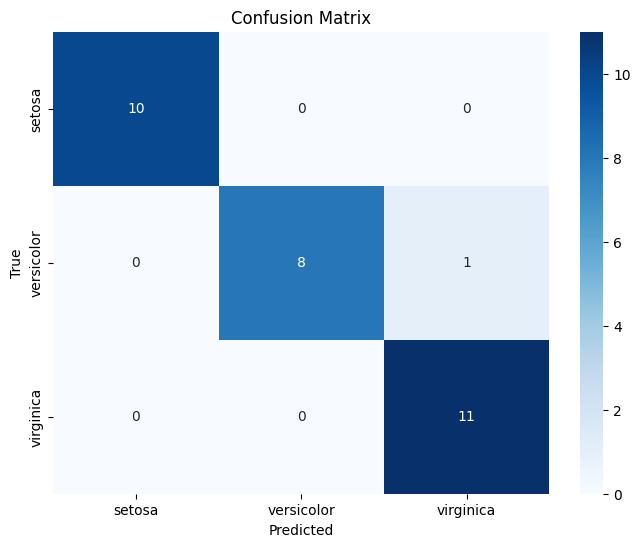


Baseline Model - Test Accuracy: 0.9333

Optimized Model - Test Accuracy: 0.9667


In [13]:
# Evaluate optimized model
y_pred = optimized_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print("Classification Report for Optimized Model:")
print(classification_report(y_test, y_pred_classes, target_names=iris.target_names))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compare model performances
models = {
    'Baseline': baseline_model,
    'Optimized': optimized_model
}

for name, model in models.items():
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n{name} Model - Test Accuracy: {test_accuracy:.4f}")

## Part 6: Streamlit Deployment

Save the optimized model and create a Streamlit app for deployment.

In [14]:
# Save the optimized model
optimized_model.save('iris_model.h5')

# Save the scaler
import joblib
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [15]:
# Create Streamlit app (app.py)
streamlit_code = """
import streamlit as st
import numpy as np
import tensorflow as tf
import joblib

# Load the saved model and scaler
model = tf.keras.models.load_model('iris_model.h5')
scaler = joblib.load('scaler.joblib')

# Set page title
st.title('Iris Flower Classification')

# Create input fields for features
st.header('Enter Flower Measurements')
sepal_length = st.number_input('Sepal Length (cm)', min_value=0.0, max_value=10.0, value=5.0)
sepal_width = st.number_input('Sepal Width (cm)', min_value=0.0, max_value=10.0, value=3.5)
petal_length = st.number_input('Petal Length (cm)', min_value=0.0, max_value=10.0, value=1.4)
petal_width = st.number_input('Petal Width (cm)', min_value=0.0, max_value=10.0, value=0.2)

# Create a button for prediction
if st.button('Predict Iris Type'):
    # Prepare input data
    features = np.array([[sepal_length, sepal_width, petal_length, petal_width]])
    # Scale features
    features_scaled = scaler.transform(features)
    # Make prediction
    prediction = model.predict(features_scaled)
    predicted_class = np.argmax(prediction)
    
    # Map class index to iris type
    iris_types = ['setosa', 'versicolor', 'virginica']
    predicted_type = iris_types[predicted_class]
    
    # Display prediction with probability
    st.success(f'Predicted Iris Type: {predicted_type.capitalize()}')
    st.write('Prediction Probabilities:')
    for iris_type, prob in zip(iris_types, prediction[0]):
        st.write(f'{iris_type.capitalize()}: {prob:.4f}')
"""

# Save the Streamlit app code
with open('app.py', 'w') as f:
    f.write(streamlit_code)

print("Streamlit app code has been saved to 'app.py'")
print("\nTo run the app, use the following command in the terminal:")
print("streamlit run app.py")

Streamlit app code has been saved to 'app.py'

To run the app, use the following command in the terminal:
streamlit run app.py
